In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Dataset paths
data_dir = "/content/drive/My Drive/My_Plant_Proj/Dataset/Dataset"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"

In [ ]:
# Image and training parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 10
MAX_PER_CLASS = 180  # ✅ Limit to 180 images per class

In [ ]:
# ================================
# ✅ Function to Collect Limited Images Per Class
# ================================
def get_limited_image_paths(directory, max_per_class=180):
    """ Collects at most `max_per_class` images per class. """
    image_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            all_images = os.listdir(class_path)
            selected_images = all_images[:max_per_class]  # Select first 180 images
            for img in selected_images:
                image_paths.append(os.path.join(class_path, img))
                labels.append(class_name)
    return pd.DataFrame({"filename": image_paths, "class": labels})

# Create DataFrame for training & validation
train_df = get_limited_image_paths(train_dir, MAX_PER_CLASS)
valid_df = get_limited_image_paths(valid_dir, MAX_PER_CLASS)

In [ ]:
# ================================
# ✅ Data Generators (Using DataFrame)
# ================================
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

# ✅ FIXED: Get number of classes
num_classes = len(train_generator.class_indices)

Found 3600 validated image filenames belonging to 20 classes.
Found 3600 validated image filenames belonging to 20 classes.


In [ ]:
# ================================
# ✅ Define Model (MobileNetV2 with 128x128 Input)
# ================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # ✅ FIXED: Now using correct number of classes

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

# Save model
model.save("/content/drive/My Drive/My_Plant_Proj/Dataset/mobilenetv2_fast.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2572s 45s/step - accuracy: 0.3957 - loss: 2.0905 - val_accuracy: 0.8575 - val_loss: 0.5680
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 534ms/step - accuracy: 0.9044 - loss: 0.4256 - val_accuracy: 0.9006 - val_loss: 0.3732
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 642ms/step - accuracy: 0.9543 - loss: 0.2511 - val_accuracy: 0.9189 - val_loss: 0.2991
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - accuracy: 0.9652 - loss: 0.1785 - val_accuracy: 0.9231 - val_loss: 0.2695
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 528ms/step - accuracy: 0.9771 - loss: 0.1486 - val_accuracy: 0.9261 - val_loss: 0.2462
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 536ms/step - accuracy: 0.9839 - loss: 0.1164 - val_accuracy: 0.9375 - val_loss: 0.2179
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 530ms/step - accuracy: 0.9893 - loss: 0.0914 - val_accuracy: 0.9353 - val_loss: 0.2107
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 525ms/step - accuracy: 0.9940 - loss: 0.0713 - val_accu

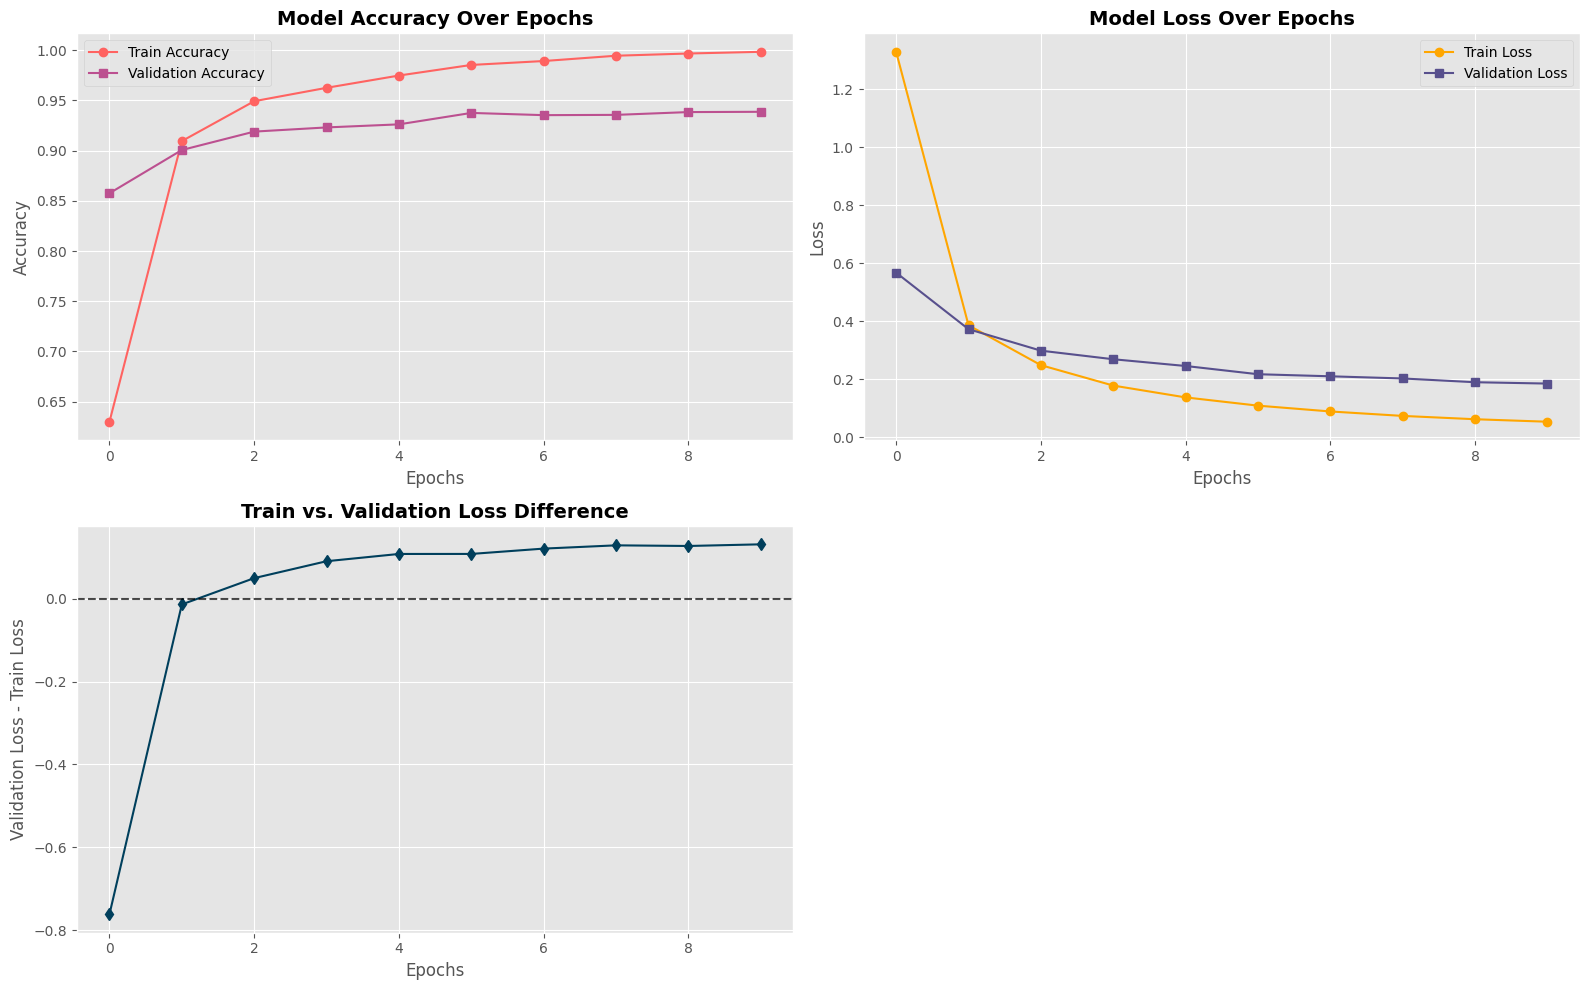

In [ ]:
# ================================
# ✅ Basic Graphical Visualizations
# ================================
plt.style.use("ggplot")  # ✅ A valid built-in style

# 🎨 Define a color palette
colors = ["#ff6361", "#bc5090", "#ffa600", "#58508d", "#003f5c", "#44bd32"]

plt.figure(figsize=(16, 10))

# 🎯 Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color=colors[0])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', color=colors[1])
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 🎯 Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color=colors[2])
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color=colors[3])
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 🎯 Train vs. Validation Loss Difference
plt.subplot(2, 2, 3)
loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
plt.plot(loss_diff, marker='d', color=colors[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('Train vs. Validation Loss Difference', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss - Train Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-26-f60db979eb32>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


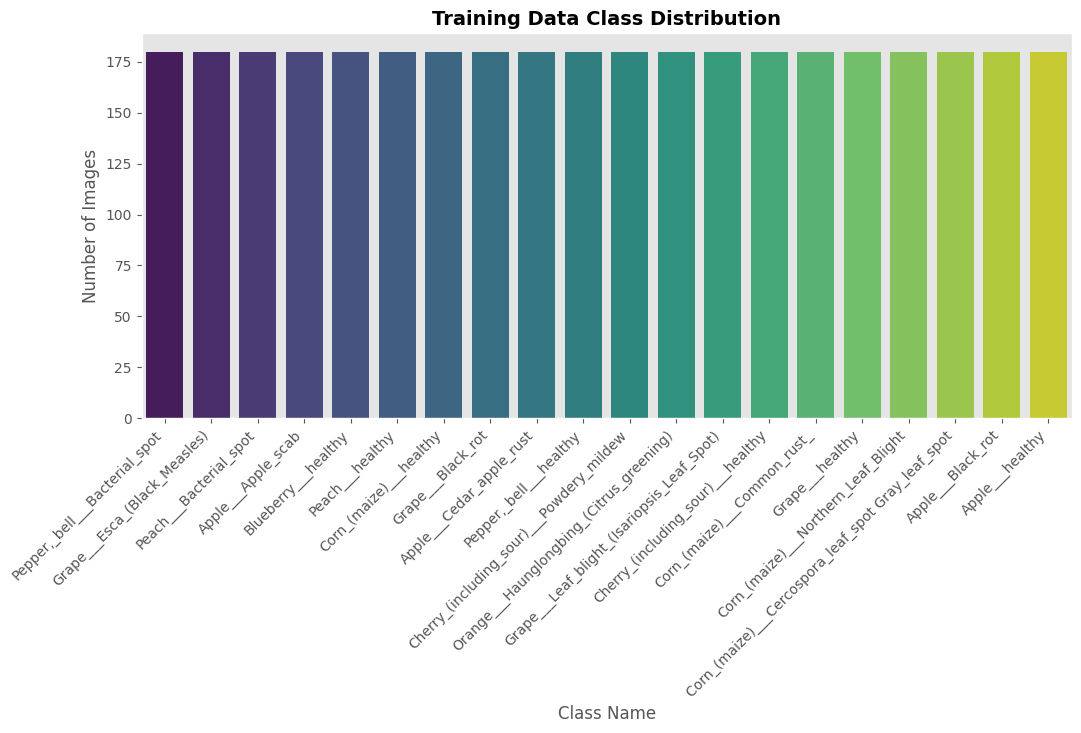

In [ ]:
# ================================
# ✅ Class Distribution in Training Data
# ================================
plt.figure(figsize=(12, 5))
class_counts = train_df['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Training Data Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step


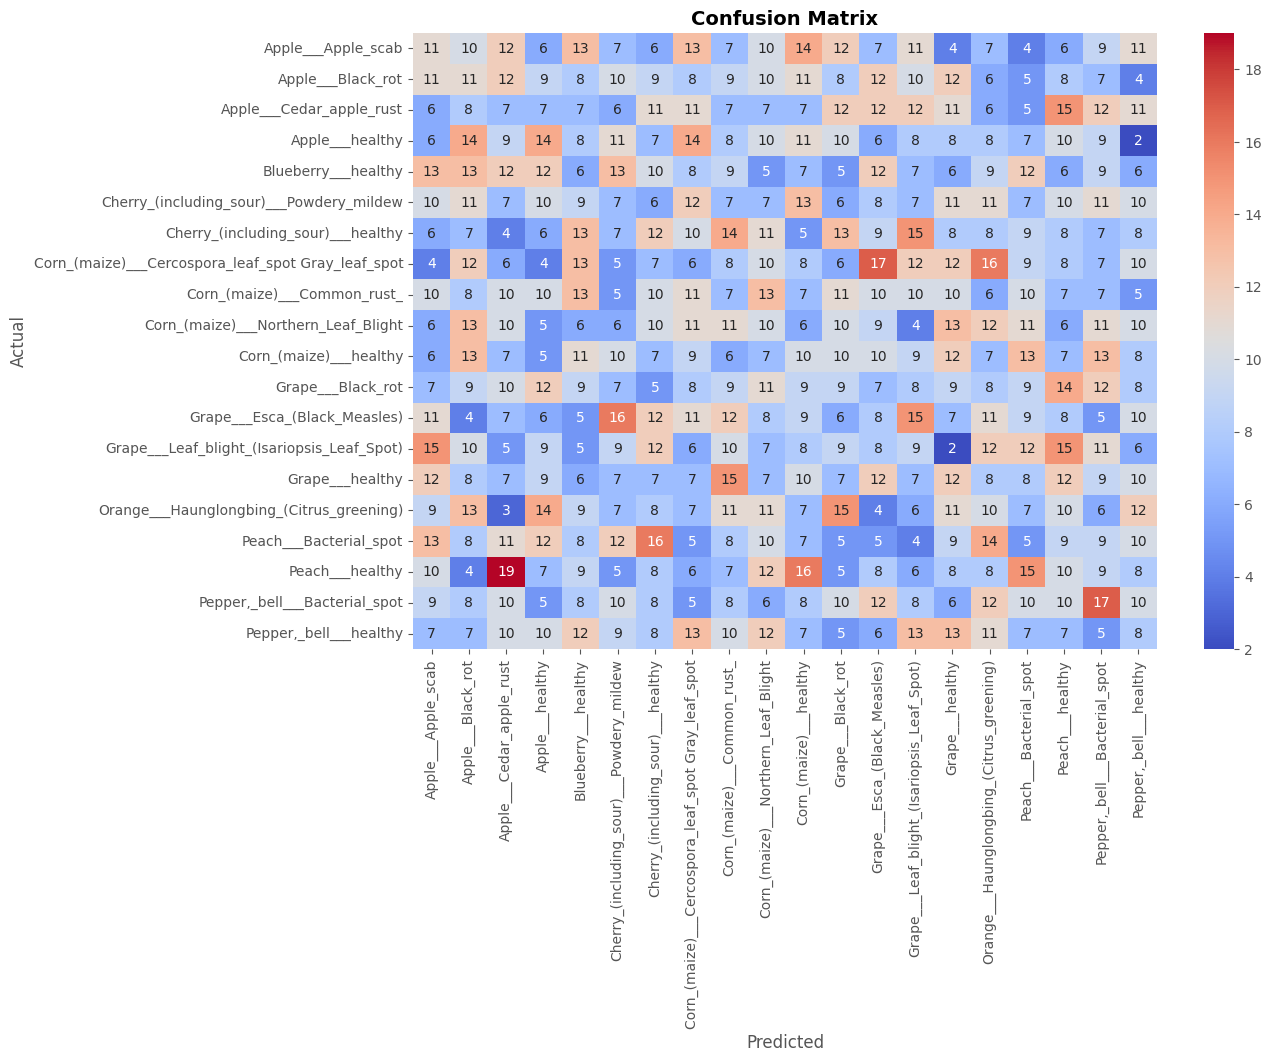

In [ ]:
# ================================
# ✅ Confusion Matrix
# ================================
y_true = valid_generator.classes
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()
